# Detect & count high-intensity spots in an image

Roughly following the tutorial from PyImageSearch[1]. The idea is to take a microscopy image and count the high intensity spots. As far as we know now (=09-01-2019, wk1 d3) the hight intensity spots are the white blood cells (Giemsa stained thick blood smears).



Steps:
1. Load the image and apply some preprocessing
2. Find focal circle by searching for the contours (will result in the focal contour)
3. Create a mask from this
4. Apply the mask so only the high intensity spots are left
5. recognize the spots so they can be counted

[1] https://www.pyimagesearch.com/2016/10/31/detecting-multiple-bright-spots-in-an-image-with-python-and-opencv/

In [1]:
# !pip install imutils

In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import imutils
from imutils import contours
%matplotlib inline

In [3]:
SAMPLE_IMAGE = 'MR4_example_data/orig/2305_vs1_u11_1_Ri7cpTbEgnfAw8R6E_5.jpg'

# 1. Load image
Using a already resized (and padded) image from the ` PreProcessing1.ipynb` notebook

Image dimensions:  (200, 200)


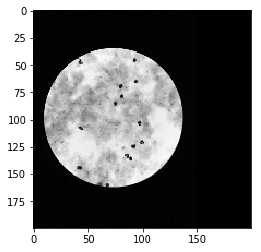

In [4]:
# Read an image with opencv in greyscale (hence the 0)
raw_img = cv.imread(SAMPLE_IMAGE, 0)

print("Image dimensions: ",raw_img.shape)

# Plotting the image with matplotlib
# Be aware, with matplotlib you have to specify a colormap, which is greyscale in this case (otherwise you get weird colors)
plt.imshow(raw_img, cmap = plt.cm.gray)

In [5]:
raw_img_shape = raw_img.shape[0]

## Blur the image
To smoothen some the colors

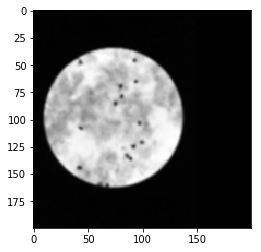

In [6]:
blur_size = 5
blurred_img = cv.GaussianBlur(raw_img, (blur_size, blur_size), 0)
plt.imshow(blurred_img, cmap=plt.cm.gray)

## Make black/white (thresholding)
To turn the image from grayscale black and white. Parameters are cutoff and color; pixels above `cutoff` are set to `color`

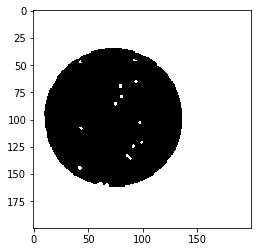

In [7]:
cutoff = 100
color = 255
thresh_img = cv.threshold(blurred_img, cutoff, color, cv.THRESH_BINARY)[1]
plt.imshow(thresh_img, cmap=plt.cm.binary)

# 2. Find contours
It appears that it finds the large circle as the main contour.

In [8]:
cnts = cv.findContours(thresh_img.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = contours.sort_contours(cnts)[0]

cnts # <= is a python list of contours

(array([[[ 66,  35]],
 
        [[ 65,  36]],
 
        [[ 60,  36]],
 
        [[ 59,  37]],
 
        [[ 56,  37]],
 
        [[ 55,  38]],
 
        [[ 53,  38]],
 
        [[ 52,  39]],
 
        [[ 51,  39]],
 
        [[ 50,  40]],
 
        [[ 49,  40]],
 
        [[ 48,  41]],
 
        [[ 46,  41]],
 
        [[ 45,  42]],
 
        [[ 44,  42]],
 
        [[ 41,  45]],
 
        [[ 39,  45]],
 
        [[ 37,  47]],
 
        [[ 36,  47]],
 
        [[ 33,  50]],
 
        [[ 32,  50]],
 
        [[ 26,  56]],
 
        [[ 26,  57]],
 
        [[ 22,  61]],
 
        [[ 22,  62]],
 
        [[ 21,  63]],
 
        [[ 21,  64]],
 
        [[ 20,  65]],
 
        [[ 20,  66]],
 
        [[ 18,  68]],
 
        [[ 18,  69]],
 
        [[ 17,  70]],
 
        [[ 17,  71]],
 
        [[ 15,  73]],
 
        [[ 15,  75]],
 
        [[ 14,  76]],
 
        [[ 14,  78]],
 
        [[ 13,  79]],
 
        [[ 13,  82]],
 
        [[ 12,  83]],
 
        [[ 12,  85]],
 
        [[ 11,  

In [9]:
print("Number of contours found: ", len(cnts))

Number of contours found:  1


In [10]:
# You can draw a bounding box with this function if you want
# (x,y,w,h) = cv.boundingRect(c)
# print(x,y,w,h)

# 3. Create the focal mask
Focal mask is something I came up with myself. To remove the large circle from the microscope I did the following:
1. Retrieve the contour of the large circle
2. Retrieve the enclosing circle of this contour (results in a X,Y pair of the center and a radius)
3. Create a black image with the same dimension as the input image
4. Plot the circle into the black image: this gives us the 'focal mask' of the large circle contour
5. Invert the colors of the focal mask (so the outer part becomes white=255, inner part black=0)
6. Add the focal mask to the thresholded image. By doing so, white=255 is added to the outer black=0 part of the thresholded image, making the outer part white. The inner part is left untouched as only 0 is added.
7. 'Normalize' the values: make them 0 or 255
8. Done

In [11]:
# Select the first contour (the large circle)
c = cnts[0]

# Calculate the circle from this contour: this returns the center point and the radius
((cX, cY), radius) = cv.minEnclosingCircle(c)
print(cX, cY, radius)

73.28271484375 98.21986389160156 63.732147216796875


[  0. 255.]


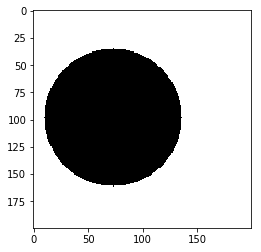

In [12]:
# Start with a black image
focal_mask = np.zeros((raw_img_shape,raw_img_shape))

# Draw a circle based on the found contour, and fill it with white
#   the circle is filled by setting the border size to -1000 -> this creates a border of size 1000 to the inner of the contour
cv.circle(focal_mask, (int(cX), int(cY)), int(radius), (255,255,255), -1000 )

# Make focal mask binary (by setting all non-zero to 1) and flip the bits
focal_mask[ focal_mask > 0 ] = 1
focal_mask = 1-focal_mask

# Multiply with 255 so every element that is 1 becomes 255
focal_mask = focal_mask * 255

print(np.unique(focal_mask))
plt.imshow(focal_mask, cmap=plt.cm.gray)

# 4. Remove focal circle

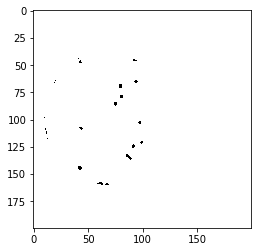

In [13]:
# Add the focal mask
neutral_img = thresh_img+focal_mask

# 'Normalize' the values: either 0 or 255
neutral_img[np.isnan(neutral_img)] = 255
neutral_img[ neutral_img < 128 ] = 0
neutral_img[ neutral_img >= 128 ] = 255

# Show the end result
plt.imshow(neutral_img, cmap=plt.cm.gray)

# 5. Find the high intensity dots
My initial approach was to do this with opencv's findContours, but it doesnt really seem to work as it only finds one ... ?

The end result should be: the number of high intensity dots... good luck

In [15]:
cnts2 = cv.findContours(cv.convertScaleAbs(neutral_img.copy()), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cnts2 = imutils.grab_contours(cnts2)
cnts2 = contours.sort_contours(cnts2)[0]

print("It should find around 12 dots ...")
print("Found contours: ",len(cnts2))

It should find around 12 dots ...
Found contours:  1
